## This notebook is for Linear stability analysis of the circuit, and uses the search result from parameter search in the preliminary analysis. In the previous one, $b_i$, $V_i$, $\mu_i$, $K_{Ai}$, $K_{Bi}$ and $K_{Ci}$ are taken the same. 

![Circute 3954](3954.png "Circute 3954")

## Here, we extend the search by starting from these points.

In [1]:
%config Completer.use_jedi = False
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from itertools import product
from scipy.optimize import fsolve
from scipy.linalg import eigvals

from tqdm import tqdm

import sys
sys.path.append("/end/home/rh2310/morpho_repo/amplitude_method")
from utils import *

sys.path.append("/end/home/rh2310/morpho_repo")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954

In [2]:
#init_printing(use_latex='mathjax')#(use_latex=True)

#### Define a list of parameters

In [3]:
A, B, C = symbols('A, B, C', real=True, positive = True)

D_A, D_B = symbols('D_A, D_B', real=True, positive = True)

(b_A, b_B, b_C,
 V_A, V_B, V_C,
K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC,
μ_A, μ_B, μ_C) = symbols(
    'b_A, b_B, b_C, V_A, V_B, V_C, K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC, mu_A, mu_B, mu_C', 
    real=True, positive = True)

k, n = symbols('k, n', integer=True)

> The PDEs are as follows

<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

![Circute 3954](3954.png "Circute 3954")

Then, we define kinetic terms as

<h3><center>$f_A(A, B, C) = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A$</center></h3>
<h3><center>$f_B(A, B, C) = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B$</center></h3>
<h3><center>$f_C(A, B, C) = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C$</center></h3>


In [4]:
def act(x, K, n):
    return 1/(1 + (K/x)**n)

def inh(x, K, n):
    return 1/(1 + (x/K)**n)


fA = b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - μ_A * A
fB = b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - μ_B * B
fC = b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - μ_C * C

lprint(r"$f_A(A, B, C) =$ {0}", fA)
lprint(r"$f_B(A, B, C) =$ {0}", fB)
lprint(r"$f_C(A, B, C) =$ {0}", fC)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### which as a vector, we can define it like

In [5]:
Kinetic = Matrix([[fA], [fB], [fC]])
lprint(r"$\boldsymbol{f}(A, B, C) =$ {0} ", Kinetic)

<IPython.core.display.Latex object>

# Load the parameters that we found for the following assumptions:
> <center>$     b_A = b_B = b_C, $</center>
> <center>$     V_A = V_B = V_C, $</center>
> <center>$     \mu_A = \mu_B = \mu_C, $</center>
> <center>$     K_{AA} = K_{AB} = K_{AC}, $</center>
> <center>$     K_{BA} = K_{BC}, $</center>
> <center>$     K_{CB} = K_{CC}. $</center>

#### First, we find the fix points of the system without diffusion. 


The solution of the above system finds $A^*, B^*, C^*$ such that
<center>$f_A(A^*, B^*, C^*) = 0$</center>
<center>$f_B(A^*, B^*, C^*) = 0$</center>
<center>$f_C(A^*, B^*, C^*) = 0$</center>

In [6]:
f1 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
               fA,
              modules='numpy')

f2 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
              fB,
              modules='numpy')

f3 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
               fC,
              modules='numpy')

def create_func(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC):
    def f_1(args):
        A,B,C = args
        return (f1(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C),
                f2(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C),
                f3(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C)) 
    
    return f_1

#### Next, to linearise the PDE system, we find the Jacobian of $(f_A, f_B, f_C)$ 

In [7]:
J_jac = Kinetic.jacobian([A, B, C])
hprint(r"J= \frac{\partial \boldsymbol{f}_i}{\partial u_j} = ", J_jac)
J_jac_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                       b_B, μ_B, V_B, K_BA, K_BC,
                       b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
                       J_jac,
              modules='numpy')

<IPython.core.display.Latex object>

## Including the diffusion

In [8]:
J_jac_diff = J_jac - Matrix([[D_A*k**2, 0,        0], 
                             [0,        D_B*k**2, 0],
                             [0,        0,        0],
                           ])
hprint(r"J_{diff}= ", J_jac_diff)

J_jac_diff_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                            b_B, μ_B, V_B, K_BA, K_BC,
                            b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
               J_jac_diff,
              modules='numpy')

<IPython.core.display.Latex object>

# Select the subset that is Turing or Hopf

In [9]:
# Combine three arrays to construct continuous curves
def combine(d1, d2, d3, deltaX):
    dc1 = np.zeros_like(d1)
    dc2 = np.zeros_like(d2)
    dc3 = np.zeros_like(d3)
    
    def distance(y1, y2):
        return (np.real(y1) - np.real(y2))**2 + deltaX**2
    def get_three(i):
        return (d1[i], d2[i], d3[i])                    
        
    # init
    dc1[0], dc2[0], dc3[0] = get_three(0)
    # next closest
    next_i = get_three(1) 
    #print(dc1[0], dc2[0], dc3[0])
    #print(next_i)
    index1 = np.argmin([distance(dc1[0], y2) for y2 in next_i])
    dc1[1] = next_i[index1]
    next_i = tuple(next_i[i] for i in [0,1,2] if i != index1)    
    #print(index1, next_i)
    index2 = np.argmin([distance(dc2[0], y2) for y2 in next_i])
    dc2[1] = next_i[index2]
    dc3[1] = tuple(next_i[i] for i in [0,1] if i != index2)[0]
    #print(dc1[1], dc2[1], dc3[1])     
    for i in range(2, dc1.shape[0]):
        #print()        
        next_i = get_three(i)
        #print(next_i)
        index1 = np.argmin([distance(2*dc1[i-1] - dc1[i-2], y2) for y2 in next_i])
        dc1[i] = next_i[index1]
        next_i = tuple(next_i[i] for i in [0,1,2] if i != index1)
        #print(index1, next_i)
        index2 = np.argmin([distance(2*dc2[i-1] - dc2[i-2], y2) for y2 in next_i])
        dc2[i] = next_i[index2]
        dc3[i] = tuple(next_i[i] for i in [0,1] if i != index2)[0]
        #print(dc1[i], dc2[i], dc3[i])  
    return dc1, dc2, dc3
        
        

In [10]:
def find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                   verbose=False):    
    func = create_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    #
    roots_res = []
    for init_vals in product([.1,-.1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res
    for init_vals in product([1,-1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([10,-10], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([100,-100], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    if len(roots_res) == 0:
        if verbose:
            print(msg)
            print("roots:", roots)
            print("values", a_1, b_1, c_1)
        return roots_res 
    else:
        roots_res2 = [roots_res[0]]
        for item in roots_res[1:]:
            if np.any(item < 0):
                continue
            if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                roots_res2.append(item)
        return roots_res2 

def get_dispersions(ks, 
                    n_val, 
                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val):
    
    roots_all = find_roots(n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    dis_list = []

    for roots in roots_all:
        A_star, B_star, C_star = roots
        print(A_star, B_star, C_star)    
        #print(A_star, B_star, C_star)
        λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                                  {n:n_val, 
                                   b_A:b_A_val, 
                                   μ_A:mu_A_val, 
                                   V_A:V_A_val,
                                   K_AA:K_AA_val, 
                                   K_AB:K_AB_val,  
                                   K_AC:K_AC_val,
                                   b_B:b_B_val, 
                                   μ_B:mu_B_val, 
                                   V_B:V_B_val,
                                   K_BA:K_BA_val, 
                                   K_BC:K_BC_val,  
                                   b_C:b_C_val, 
                                   μ_C:mu_C_val, 
                                   V_C:V_C_val,
                                   K_CB:K_CB_val, 
                                   K_CC:K_CC_val,  
                                   A:A_star, 
                                   B:B_star, 
                                   C:C_star,
                                   D_A:0.01,
                                   D_B:1.0}
                             ).eigenvals().keys())

        λ_1_func = lambdify([k], 
                             λ_1,
                             modules='numpy')
        λ_2_func = lambdify([k], 
                             λ_2,
                             modules='numpy')
        λ_3_func = lambdify([k], 
                             λ_3,
                             modules='numpy')
        
        dis1 = λ_1_func(ks)        
        dis2 = λ_2_func(ks)        
        dis3 = λ_3_func(ks)   

        dis_list.append((dis1, dis2 ,dis3))
        
    return dis_list



In [11]:
def plot_dispersion(index, parameters, k_maxs, ks=None):
    (n_val, 
    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = parameters[index]
    print("Parameters - ")
    print("""n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC""")
    print(n_val)
    print(b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val)
    print(b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val)
    print(b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)

    if ks is None:
        k_max = k_maxs[index]
        print("k_max:", k_max)
        ks = np.linspace(0, k_max + 1, 10000).astype(np.complex64)
    #ks = np.linspace(0, 5, 100).astype(np.complex64)

    for dis1, dis2, dis3 in get_dispersions(ks, n_val, 
                        b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                        b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                        b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val): 
        #dis1, dis2, dis3 = combine(dis1, dis2, dis3, ks[1] - ks[0])
        plt.figure(figsize=(14,5))
        plt.subplot(131)
        plt.title(f"{np.count_nonzero(np.real(dis1) > 0) > 1}")
        plt.plot(ks, np.real(dis1))
        plt.plot(ks, np.imag(dis1))
        plt.xlabel("k")
        plt.grid()
        plt.subplot(132)
        plt.title(f"{np.count_nonzero(np.real(dis2) > 0) > 1}")
        plt.plot(ks, np.real(dis2))
        plt.plot(ks, np.imag(dis2))
        plt.xlabel("k")
        plt.grid()
        plt.subplot(133)
        plt.title(f"{np.count_nonzero(np.real(dis3) > 0) > 1}")
        plt.plot(ks, np.real(dis3))
        plt.plot(ks, np.imag(dis3))
        plt.xlabel("k")
        plt.grid();plt.tight_layout();plt.show()
    


In [12]:
# with open('turing_stationary_parameters_set_2.npy', 'wb') as f:
#     np.save(f, turing_stationary_parameters)

# with open('turing_stationary_k_max_set_2.npy', 'wb') as f:
#     np.save(f, turing_stationary_k_max)



# ########################################################
# with open('turing_hopf_parameters_set_2.npy', 'wb') as f:
#     np.save(f, turing_hopf_parameters)

# with open('turing_hopf_k_max_set_2.npy', 'wb') as f:
#     np.save(f, turing_hopf_k_max)



with open('./Three_nodes_models/circuit_3954/turing_stationary_parameters_set_2.npy', 'rb') as f:
    turing_stationary_parameters = np.load(f)

with open('./Three_nodes_models/circuit_3954/turing_stationary_k_max_set_2.npy', 'rb') as f:
    turing_stationary_k_max = np.load(f)

with open('./Three_nodes_models/circuit_3954/turing_hopf_parameters_set_2.npy', 'rb') as f:
    turing_hopf_parameters = np.load(f)
    
with open('./Three_nodes_models/circuit_3954/turing_stationary_k_max_set_2.npy', 'rb') as f:
    turing_hopf_k_max = np.load(f)

In [16]:
np.set_printoptions(precision=3, suppress=True)

In [15]:
turing_stationary_parameters[144]  

array([4.0e+00, 1.0e-03, 1.0e-01, 1.0e+01, 1.0e-01, 5.0e-01, 2.0e+01,
       1.0e-01, 1.0e+00, 5.0e+01, 5.0e-01, 1.0e+01, 5.0e-01, 1.0e-01,
       2.5e+01, 1.0e+02, 1.0e+02])

In [13]:
ps = (4.0, 
     0.1, 0.5, 25.0, 1.0, 5.0, 5.0, 
     1.0, 1.0, 20.0, 10.0, 20.0,
     0.001, 0.1, 5.0, 25.0, 20.0
 )
(n_val, 
    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = ps

In [29]:
for i, item in enumerate(turing_stationary_parameters):
    if np.all(item == ps):
        print(i, item)
        break

33413 [4.0e+00 1.0e-01 5.0e-01 2.5e+01 1.0e+00 5.0e+00 5.0e+00 1.0e+00 1.0e+00
 2.0e+01 1.0e+01 2.0e+01 1.0e-03 1.0e-01 5.0e+00 2.5e+01 2.0e+01]


In [15]:
import warnings
warnings.filterwarnings('ignore')

Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
0.1 0.5 25.0 1.0 5.0 5.0
1.0 1.0 20.0 10.0 20.0
0.001 0.1 5.0 25.0 20.0
6.636736551690758 16.126846400664743 0.00999999943383578


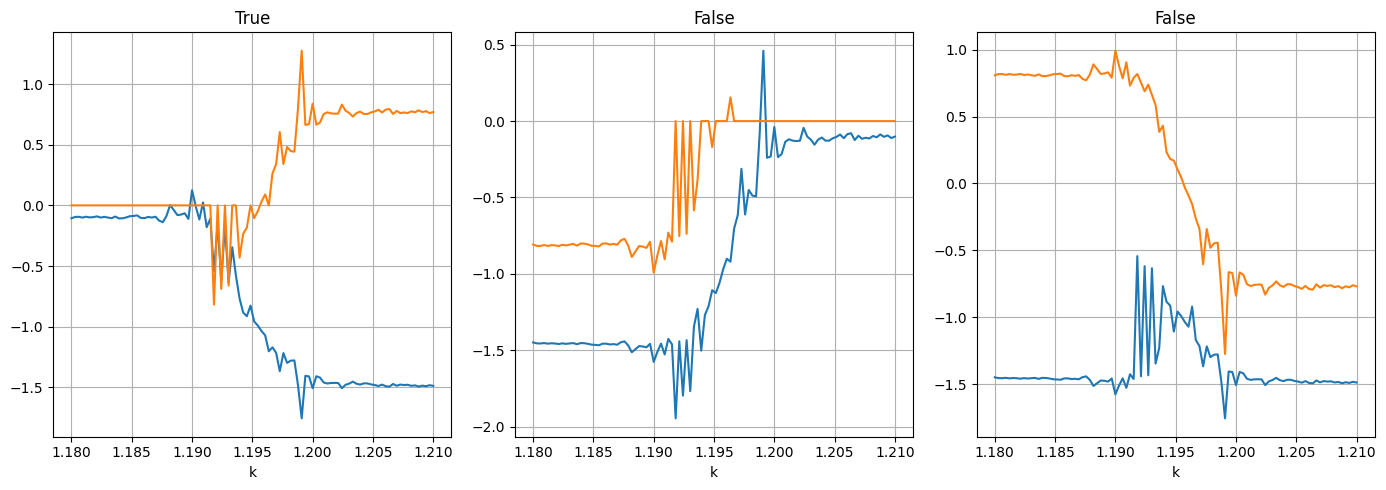

In [16]:
plot_dispersion(33413, turing_stationary_parameters, turing_stationary_k_max,
                np.linspace(1.18, 1.21, 100).astype(np.complex64))

In [41]:
2*np.pi*1.19

7.476990515543707

In [14]:
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase/pde_solvers")
from cn import RD_2D_1st_Order as RDSolver
from cn import Neumann_Boundary_2D
from cn import Periodic_Boundary_2D

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase/turing")
from three_nodes_circuits import create_circuit_3954

In [15]:
delta_t = 0.01
Lx = Ly = 1.0
D_A, D_B = 0.01, 1.0
solver = RDSolver(Ds=[D_A, D_B, 0], 
                  delta_t=delta_t, 
                  Lx=Lx, Ly=Ly, 
                  Ix=64, Jy=64,
                  boundary_condition=Periodic_Boundary_2D)

/end/home/rh2310/.conda/envs/numba/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [17]:
initial_A = 6.636736551690749 * np.ones((64, 64)) 
initial_A += np.random.normal(scale=.01, size=(64, 64))

initial_B = 16.126846400664757 * np.ones((64, 64)) 
initial_B += np.random.normal(scale=.01, size=(64, 64))

initial_C=  0.0099999994338246* np.ones((64, 64)) 
initial_C += np.random.normal(scale=.01, size=(64, 64))

In [19]:
A_star, B_star, C_star = find_roots(n_val, 
    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)[0]

In [20]:
initial_A = A_star * np.ones((64, 64)) 
initial_A += np.random.normal(scale=.01, size=(64, 64))

initial_B = B_star * np.ones((64, 64)) 
initial_B += np.random.normal(scale=.01, size=(64, 64))

initial_C=  C_star * np.ones((64, 64)) 
initial_C += np.random.normal(scale=.01, size=(64, 64))

In [21]:
kinetic = create_circuit_3954(n_val, 
    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)

In [22]:
steps = 10000
solutions = solver.integrate([initial_A.flatten(), 
                              initial_B.flatten(),
                              initial_C.flatten()] ,
                              kinetic,
                              steps,
                              record_steps=100)

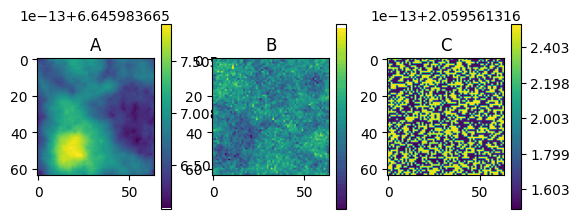

In [23]:
A_n = solutions[-1, 0, :].reshape((64,64))
B_n = solutions[-1, 1, :].reshape((64,64))
C_n = solutions[-1, 2, :].reshape((64,64))

plt.subplot(131)
plt.imshow(A_n)
plt.colorbar(shrink=.5)
plt.title("A")
plt.subplot(132)
plt.imshow(B_n)
plt.colorbar(shrink=.5)
plt.title("B")
plt.subplot(133)
plt.imshow(C_n)
plt.colorbar(shrink=.5)
plt.title("C")
plt.show()

Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
0.001 0.5 25.0 5.0 5.0 5.0
0.001 5.0 100.0 10.0 10.0
1.0 0.5 25.0 5.0 5.0
6.645983663271499 14.723677954396189 2.0595613145672935


/end/home/rh2310/.conda/envs/numba/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


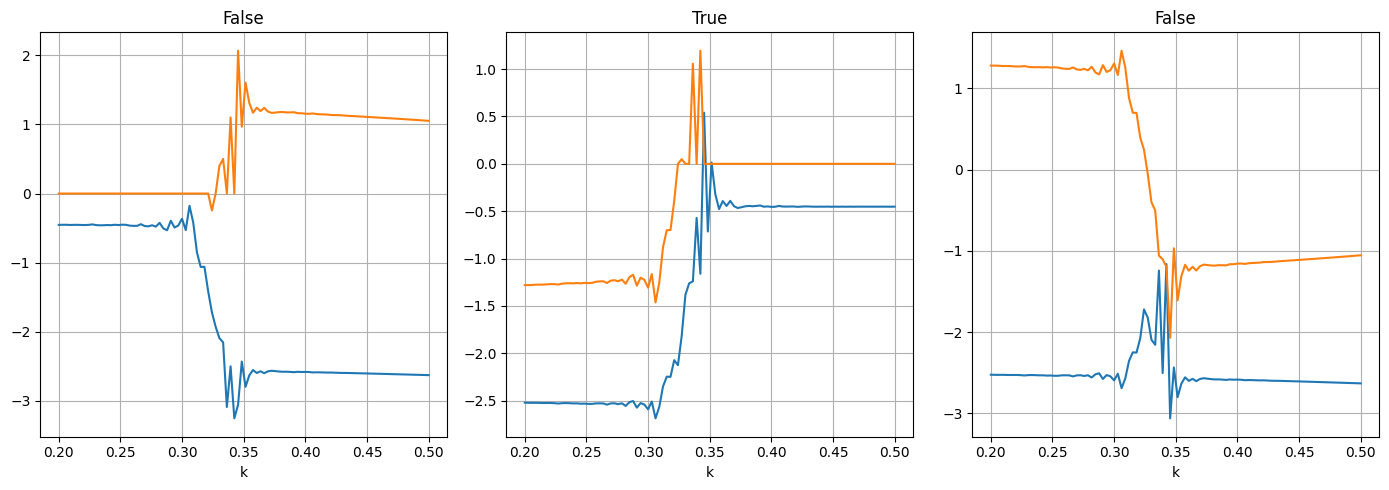

In [12]:
plot_dispersion(0, np.array([[4.0e+00, 1.0e-03, 5.0e-01, 2.5e+01, 5.0e+00, 5.0e+00, 5.0e+00,
       1.0e-03, 5.0e+00, 1.0e+02, 1.0e+01, 1.0e+01, 1.0e+00, 5.0e-01,
       2.5e+01, 5.0e+00, 5.0e+00]]),None, np.linspace(0.2,.5,100).astype(np.complex64))